In [1]:
!git clone https://github.com/YoongiKim/CIFAR-10-images.git

Cloning into 'CIFAR-10-images'...
remote: Enumerating objects: 60027, done.
remote: Total 60027 (delta 0), reused 0 (delta 0), pack-reused 60027
Receiving objects: 100% (60027/60027), 19.94 MiB | 57.52 MiB/s, done.
Resolving deltas: 100% (59990/59990), done.
Updating files: 100% (60001/60001), done.


In [2]:
import os
import random
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [3]:
TRAINING_DIRECTORY = 'CIFAR-10-images/test'
CATEGORIES_LIST = []
for category in os.listdir(TRAINING_DIRECTORY):
    CATEGORIES_LIST.append(category)
print(CATEGORIES_LIST)

['horse', 'ship', 'frog', 'cat', 'automobile', 'dog', 'bird', 'deer', 'truck', 'airplane']


In [4]:
TRAINING_DATA = []
for category in CATEGORIES_LIST:
    path = os.path.join(TRAINING_DIRECTORY, category)
    class_number = CATEGORIES_LIST.index(category)
    for image_file in tqdm(os.listdir(path)):
        image_array = cv2.imread(os.path.join(path, image_file), cv2.IMREAD_GRAYSCALE)
        TRAINING_DATA.append([image_array, class_number])
print(len(TRAINING_DATA))

random.shuffle(TRAINING_DATA)

100%|██████████| 1000/1000 [00:00<00:00, 29827.65it/s]


10000


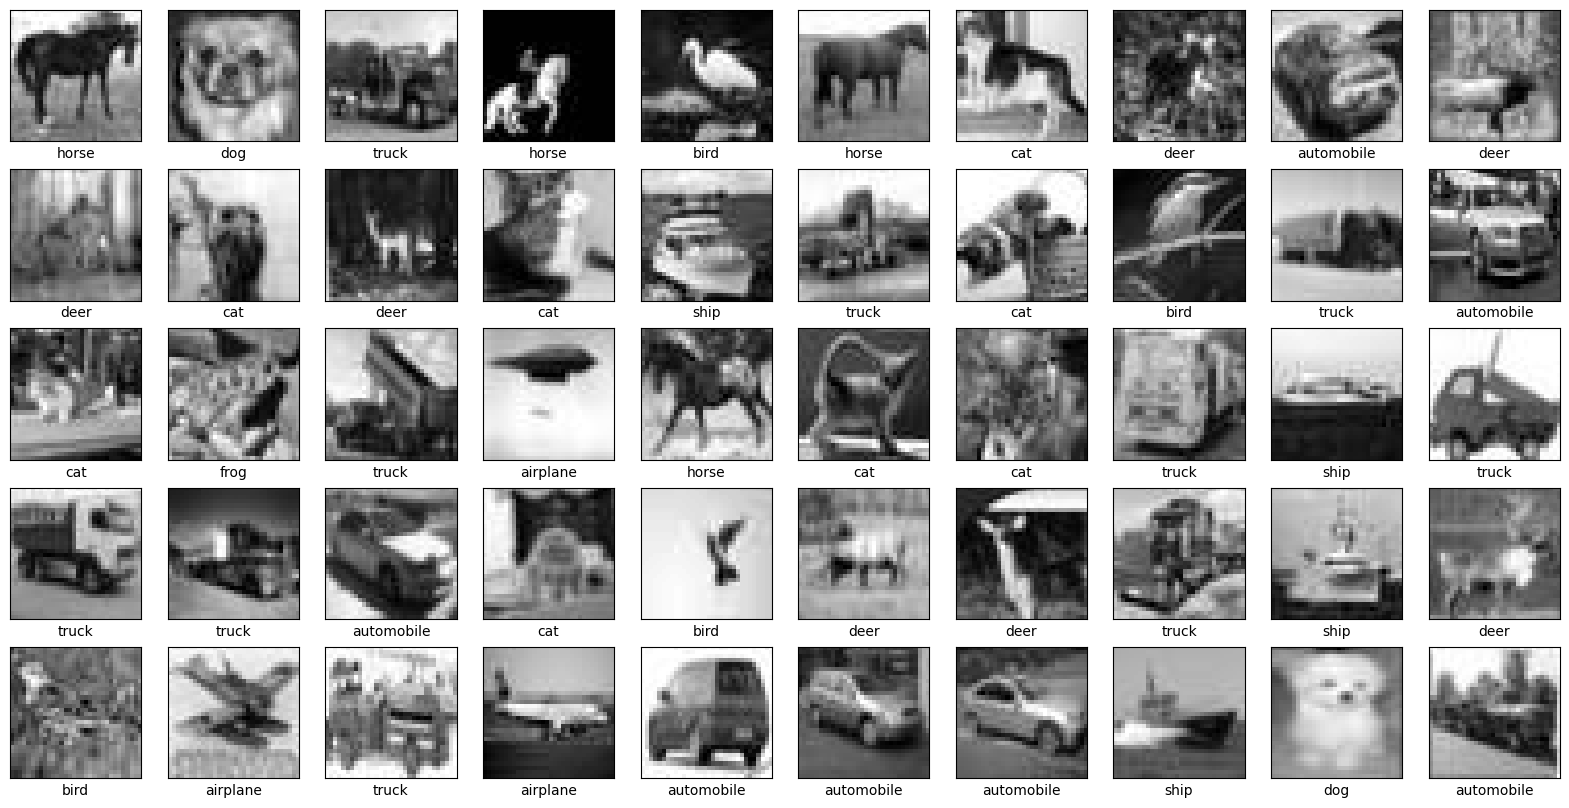

In [6]:
plt.figure(figsize=(20, 10))

for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(TRAINING_DATA[i][0], cmap='gray')
    plt.xlabel(CATEGORIES_LIST[TRAINING_DATA[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i == 50:
        break
plt.show()

In [7]:
fold_0 = TRAINING_DATA[:200]
fold_1 = TRAINING_DATA[200:400]
fold_2 = TRAINING_DATA[400:600]
fold_3 = TRAINING_DATA[600:800]
fold_4 = TRAINING_DATA[800:1000]

In [8]:
def plot_accuracies(fold_num, k_values, accuracy_data):
    best_result = [0, 0]
    for k in k_values:
        accuracy_values = accuracy_data[k]
        if best_result[1] < max(accuracy_values):
            best_result[0] = k
            best_result[1] = max(accuracy_values)
        plt.scatter([k] * len(accuracy_values), accuracy_values)

    accuracies_mean = np.array([np.mean(values) for key, values in sorted(accuracy_data.items())])
    accuracies_std = np.array([np.std(values) for key, values in sorted(accuracy_data.items())])
    plt.errorbar(k_values, accuracies_mean, yerr=accuracies_std)
    plt.title(f"Cross-validation   fold={fold_num}   K={best_result[0]}   Accuracy = {best_result[1]}")
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.show()

In [9]:
k_values = [1, 3, 5, 7, 9]
k_values_error_l1 = {}
k_values_error_l2 = {}
for k in k_values:
    k_values_error_l1[k] = []
    k_values_error_l2[k] = []


In [10]:
midpoint_l1_accuracies = []
midpoint_l2_accuracies = []

for i in range(5):
    if i == 0:
        training_set = fold_1 + fold_2 + fold_3 + fold_4
        validation_set = fold_0
    elif i == 1:
        training_set = fold_0 + fold_2 + fold_3 + fold_4
        validation_set = fold_1
    elif i == 2:
        training_set = fold_0 + fold_1 + fold_3 + fold_4
        validation_set = fold_2
    elif i == 3:
        training_set = fold_0 + fold_1 + fold_2 + fold_4
        validation_set = fold_3
    elif i == 4:
        training_set = fold_0 + fold_1 + fold_2 + fold_3
        validation_set = fold_4

    l1_accuracies = []
    l2_accuracies = []
    for k in k_values:
        l1_correct = 0
        l2_correct = 0
        total = 0
        for validation_data in tqdm(validation_set):
            v_img = validation_data[0]
            v_label = validation_data[1]
            l1_scores = []
            l2_scores = []
            for training_data in training_set:
                t_img = training_data[0]
                t_label = training_data[1]

                l1_dist = np.sum(np.abs(t_img - v_img))
                l1_scores.append((l1_dist, t_label))

                l2_dist = np.sqrt(np.sum((t_img - v_img) ** 2))
                l2_scores.append((l2_dist, t_label))
            sorted_l1_scores = sorted(l1_scores, key=lambda x: x[0])[:k]
            l1_neighbors = [s[1] for s in sorted_l1_scores]
            l1_prediction = max(set(l1_neighbors), key=l1_neighbors.count)

            sorted_l2_scores = sorted(l2_scores, key=lambda x: x[0])[:k]
            l2_neighbors = [s[1] for s in sorted_l2_scores]
            l2_prediction = max(set(l2_neighbors), key=l2_neighbors.count)
            if l1_prediction == v_label:
                l1_correct += 1
            if l2_prediction == v_label:
                l2_correct += 1

            total += 1

        l1_accuracy = l1_correct / total
        l1_accuracies.append(l1_accuracy)
        k_values_error_l1[k].append(l1_accuracy)

        l2_accuracy = l2_correct / total
        l2_accuracies.append(l2_accuracy)
        k_values_error_l2[k].append(l2_accuracy)

        print("Fold {}, k = {}, L1 accuracy = {:.2f}%, L2 accuracy = {:.2f}%".format(i, k, l1_accuracy * 100, l2_accuracy * 100))

    min_l1_accuracy = min(l1_accuracies)
    max_l1_accuracy = max(l1_accuracies)
    midpoint_l1_accuracy = (min_l1_accuracy + max_l1_accuracy) / 2
    midpoint_l1_accuracies.append(midpoint_l1_accuracy)

    min_l2_accuracy = min(l2_accuracies)
    max_l2_accuracy = max(l2_accuracies)
    midpoint_l2_accuracy = (min_l2_accuracy + max_l2_accuracy) / 2
    midpoint_l2_accuracies.append(midpoint_l2_accuracy)

100%|██████████| 200/200 [00:02<00:00, 90.53it/s]


Fold 0, k = 1, L1 accuracy = 15.50%, L2 accuracy = 14.50%


100%|██████████| 200/200 [00:02<00:00, 68.15it/s]


Fold 0, k = 3, L1 accuracy = 13.50%, L2 accuracy = 12.50%


100%|██████████| 200/200 [00:02<00:00, 91.38it/s]


Fold 0, k = 5, L1 accuracy = 15.00%, L2 accuracy = 11.50%


100%|██████████| 200/200 [00:02<00:00, 90.61it/s]


Fold 0, k = 7, L1 accuracy = 16.50%, L2 accuracy = 17.50%


100%|██████████| 200/200 [00:02<00:00, 93.84it/s]


Fold 0, k = 9, L1 accuracy = 14.00%, L2 accuracy = 21.50%


100%|██████████| 200/200 [00:02<00:00, 90.08it/s]


Fold 1, k = 1, L1 accuracy = 16.50%, L2 accuracy = 14.00%


100%|██████████| 200/200 [00:02<00:00, 67.76it/s]


Fold 1, k = 3, L1 accuracy = 11.50%, L2 accuracy = 13.00%


100%|██████████| 200/200 [00:02<00:00, 90.91it/s]


Fold 1, k = 5, L1 accuracy = 13.50%, L2 accuracy = 10.00%


100%|██████████| 200/200 [00:02<00:00, 95.02it/s]


Fold 1, k = 7, L1 accuracy = 14.00%, L2 accuracy = 12.00%


100%|██████████| 200/200 [00:02<00:00, 92.85it/s]


Fold 1, k = 9, L1 accuracy = 14.00%, L2 accuracy = 13.50%


100%|██████████| 200/200 [00:02<00:00, 93.34it/s]


Fold 2, k = 1, L1 accuracy = 19.00%, L2 accuracy = 14.50%


100%|██████████| 200/200 [00:02<00:00, 73.53it/s]


Fold 2, k = 3, L1 accuracy = 18.50%, L2 accuracy = 13.00%


100%|██████████| 200/200 [00:02<00:00, 82.97it/s]


Fold 2, k = 5, L1 accuracy = 19.50%, L2 accuracy = 12.50%


100%|██████████| 200/200 [00:02<00:00, 93.22it/s]


Fold 2, k = 7, L1 accuracy = 17.00%, L2 accuracy = 12.00%


100%|██████████| 200/200 [00:02<00:00, 92.50it/s]


Fold 2, k = 9, L1 accuracy = 17.00%, L2 accuracy = 15.50%


100%|██████████| 200/200 [00:02<00:00, 92.25it/s]


Fold 3, k = 1, L1 accuracy = 14.50%, L2 accuracy = 18.00%


100%|██████████| 200/200 [00:02<00:00, 77.74it/s]


Fold 3, k = 3, L1 accuracy = 16.50%, L2 accuracy = 15.50%


100%|██████████| 200/200 [00:02<00:00, 78.03it/s]


Fold 3, k = 5, L1 accuracy = 20.00%, L2 accuracy = 13.00%


100%|██████████| 200/200 [00:02<00:00, 89.92it/s]


Fold 3, k = 7, L1 accuracy = 19.50%, L2 accuracy = 17.00%


100%|██████████| 200/200 [00:02<00:00, 91.25it/s]


Fold 3, k = 9, L1 accuracy = 17.00%, L2 accuracy = 18.50%


100%|██████████| 200/200 [00:02<00:00, 95.34it/s]


Fold 4, k = 1, L1 accuracy = 20.00%, L2 accuracy = 13.00%


100%|██████████| 200/200 [00:02<00:00, 85.96it/s]


Fold 4, k = 3, L1 accuracy = 18.50%, L2 accuracy = 16.00%


100%|██████████| 200/200 [00:02<00:00, 71.46it/s]


Fold 4, k = 5, L1 accuracy = 19.00%, L2 accuracy = 16.50%


100%|██████████| 200/200 [00:02<00:00, 92.45it/s]


Fold 4, k = 7, L1 accuracy = 15.00%, L2 accuracy = 17.00%


100%|██████████| 200/200 [00:02<00:00, 92.67it/s]

Fold 4, k = 9, L1 accuracy = 17.00%, L2 accuracy = 17.00%


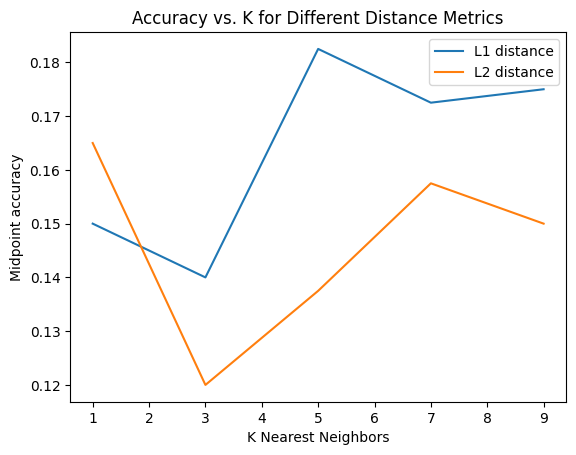

In [11]:
plt.plot(k_values, midpoint_l1_accuracies, label='L1 distance')
plt.plot(k_values, midpoint_l2_accuracies, label='L2 distance')
plt.xlabel('K Nearest Neighbors')
plt.ylabel('Midpoint accuracy')
plt.title('Accuracy vs. K for Different Distance Metrics')
plt.legend()
plt.show()

Discussion

we observe the results of the 5-fold cross-validation for both the Manhattan (L1) and Euclidean (L2) distance metrics in a classification task. These metrics were evaluated for k values of 1, 3, 5, 7, and 9.

The results show that the choice of distance metric and the value of k have a significant impact on the classification accuracy. Both L1 and L2 distances exhibit varying performance across different k values and folds.

For L1 distance, we can see that the accuracy ranges from approximately 11.50% to 20.00% across different folds and k values. The highest accuracy achieved is 20.00% in Fold 3 with k=5, while the lowest is 11.50% in Fold 1 with k=3. This suggests that L1 distance may be more sensitive to the choice of k and the composition of the training and validation sets.

For L2 distance, the accuracy ranges from around 10.00% to 18.50%. The highest accuracy is 18.50% in Fold 3 with k=3, and the lowest is 10.00% in Fold 1 with k=5. L2 distance seems to provide slightly higher accuracy in some cases, but it also exhibits variations based on the choice of k and dataset splits.

In summary, both L1 and L2 distances have their strengths and weaknesses in this classification task. The choice of the best distance metric and k value depends on the specific characteristics of the dataset and the nature of the features. The results suggest that neither distance metric consistently outperforms the other across all scenarios.